# Advansed ML. Домашнее задание №3

Данная работа выполнена в качестве домашнего задания в курсе "Продвинутое машинное обучение" в академии больших данных MADE.

В этом  домашнем задании предлагается улучшить метод Шерлока Холмса. Как известно, в рассказе The Adventure of the Dancing Men великий сыщик расшифровал загадочные письмена, которые выглядели примерно так:
 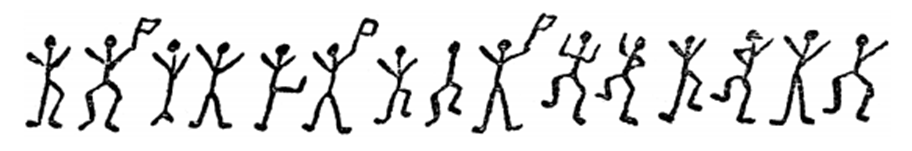
Пользовался он для этого так называемым частотным методом: смотрел, какие буквы чаще встречаются в зашифрованных текстах, и пытался подставить буквы в соответствии с частотной таблицей: E — самая частая и так далее.
В этом задании мы будем разрабатывать более современный и продвинутый вариант такого частотного метода. 

В качестве корпусов текстов возьмем отрывок из "Войны и мира".


У нас есть зашифрованное сообщение от преподавателя, которое надо расшифровать: 
დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳ
ႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂ
დႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ

In [4]:
import numpy as np
from collections import Counter
import re 
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from tqdm import tqdm
from fuzzywuzzy import fuzz

F:\Data_Science\Anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Данный примитивный код будем использовать для тестового кодирования/декодирования сообщений:

In [5]:
RUSSIAN_ALF = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '

In [6]:
CODE = {'а': '1', 'б': '2', 'в': '3', 'г': '4', 'д': '5','е': '6', 'ж': '7', 'з': '8', 'и': '9', 'й': '+','к': '*', 'л': 'Z', 'м': 'Y', 'н': 'X', 'о': 'W','п': 'V', 'р': 'U', 'с': 'T','т': 'R','у': 'P', 'ф': 'O', 'х': 'N', 
        'ц': 'M', 'ч': 'L','ш': 'K','щ': 'I', 'ъ': 'J', 'ы': 'I', 'ь': 'D','э': 'C', 'ю': 'B','я': 'A',' ': '!', '\n': '@'}

In [7]:
#Текст от преподавателя для расшифровки
TEXT_TO_DECODE = 'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

### 1. Базовая (примитивная) реализация "частотного метода Шерлока Холмса":

Подсчитаем частоты букв по корпусам (пунктуацию и капитализацию опустим, а вот пробелы оставим.

In [8]:
#загрузка корпуса
with open('WarAndPeace.txt', encoding='utf-8') as f:
    text = f.read()

#препроцесинг
text = text.lower()
text = re.sub(r'[^\w\s]','', text)
text = text.replace('\n', ' ')
text = text.replace('\t', ' ')

#получение частот униграмм
cnt = Counter(text)
frequency_of_letters = cnt.most_common(50)
frequency_of_letters[:10] #пример

[(' ', 117327),
 ('о', 61282),
 ('а', 45209),
 ('е', 42519),
 ('и', 35838),
 ('н', 35119),
 ('т', 30619),
 ('с', 28128),
 ('л', 27277),
 ('в', 24824)]

Построим гистограмму распределения символов:

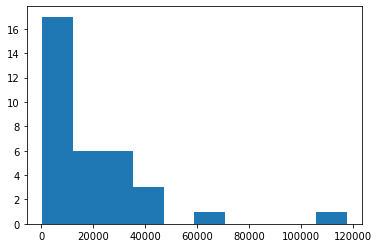

In [9]:
letters_stat = np.array([cnt[letter] for letter in RUSSIAN_ALF])
plt.hist(letters_stat);

Возьмем тестовый текст, зашифруем с помощью кодировки, описанной выше: каждый символ заменяем другим символом. Последовательность символов в тексте остается неизменной.

In [10]:
def text_to_code(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text) 
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    list_letters = list(text)
    code_list_letters = [CODE[i] for i in text]
    return ''.join(code_list_letters)

In [11]:
my_text1 = '''В романе Толстого все было современным: и общий замысел, и подробности. И все, что попадало в поле его зрения, приобретало обобщенный, почти символический характер. Например, железная дорога. Она была в те годы великим техническим новшеством, переворотившим все привычные представления о времени, пространстве и движении. Жизнь героев романа «Анна Каренина» так или иначе связана с железной дорогой. Однажды утренним поездом в Москву приехал Левин. На другой день, около полудня, из Петербурга приехала Анна Каренина. «Платформа задрожала, и, пыхая сбиваемым книзу от мороза паром, прокатился паровоз с медленно и мерно насупливающимся и растягивающимся рычагом среднего колеса…» Никто не мог теперь обойтись без железной дороги – ни светская дама из столицы, ни усадебный помещик.'''

my_text2 = '''Быть энтузиасткой сделалось ее общественным положением, и иногда, когда ей даже того не хотелось, она, чтобы не обмануть ожиданий людей, знавших ее, делалась энтузиасткой. Сдержанная улыбка, игравшая постоянно на лице Анны Павловны, хотя и не шла к ее отжившим чертам, выражала, как у избалованных детей, постоянное сознание своего милого недостатка, от которого она не хочет, не может и не находит нужным исправляться.'''

In [12]:
encrypted_text1 = text_to_code(my_text1)
encrypted_text1

'3!UWY1X6!RWZTRW4W!3T6!2IZW!TW3U6Y6XXIY!9!W2I9+!81YIT6Z!9!VW5UW2XWTR9!9!3T6!LRW!VWV151ZW!3!VWZ6!64W!8U6X9A!VU9W2U6R1ZW!W2W2I6XXI+!VWLR9!T9Y3WZ9L6T*9+!N1U1*R6U!X1VU9Y6U!76Z68X1A!5WUW41!WX1!2IZ1!3!R6!4W5I!36Z9*9Y!R6NX9L6T*9Y!XW3K6TR3WY!V6U63WUWR93K9Y!3T6!VU93ILXI6!VU65TR13Z6X9A!W!3U6Y6X9!VUWTRU1XTR36!9!53976X99!798XD!46UW63!UWY1X1!1XX1!*1U6X9X1!R1*!9Z9!9X1L6!T3A81X1!T!76Z68XW+!5WUW4W+!W5X175I!PRU6XX9Y!VW685WY!3!YWT*3P!VU96N1Z!Z639X!X1!5UP4W+!56XD!W*WZW!VWZP5XA!98!V6R6U2PU41!VU96N1Z1!1XX1!*1U6X9X1!VZ1ROWUY1!815UW71Z1!9!VIN1A!T29316YIY!*X98P!WR!YWUW81!V1UWY!VUW*1R9ZTA!V1UW3W8!T!Y65Z6XXW!9!Y6UXW!X1TPVZ931BI9YTA!9!U1TRA4931BI9YTA!UIL14WY!TU65X64W!*WZ6T1!X9*RW!X6!YW4!R6V6UD!W2W+R9TD!268!76Z68XW+!5WUW49!!X9!T36RT*1A!51Y1!98!TRWZ9MI!X9!PT1562XI+!VWY6I9*'

In [13]:
encrypted_text2 = text_to_code(my_text2)
encrypted_text2

'2IRD!CXRP891TR*W+!T56Z1ZWTD!66!W2I6TR36XXIY!VWZW76X96Y!9!9XW451!*W451!6+!5176!RW4W!X6!NWR6ZWTD!WX1!LRW2I!X6!W2Y1XPRD!W7951X9+!ZB56+!8X13K9N!66!56Z1Z1TD!CXRP891TR*W+!T56U71XX1A!PZI2*1!94U13K1A!VWTRWAXXW!X1!Z9M6!1XXI!V13ZW3XI!NWRA!9!X6!KZ1!*!66!WR793K9Y!L6UR1Y!3IU171Z1!*1*!P!9821ZW31XXIN!56R6+!VWTRWAXXW6!TW8X1X96!T3W64W!Y9ZW4W!X65WTR1R*1!WR!*WRWUW4W!WX1!X6!NWL6R!X6!YW76R!9!X6!X1NW59R!XP7XIY!9TVU13ZARDTA'

Реализуем функцию декодировщика по следующему принципу: наиболее популярному символу в закодированном сообщении ставим в соответствие наиболее популярный символ в нашем корпусе, второму по популярности символу в закодированном сообщении - второй по популярности символ в корпусе и т.д.:

In [14]:
def text_decoder(encrypted_text: str):
    cnt_code = Counter(encrypted_text)
    frequency_of_letters_code = cnt_code.most_common(30)
    decode = {}
    for i, (l, _) in enumerate(frequency_of_letters_code):
        decode[l] = frequency_of_letters[i][0]
    
    decrypted_text = ''
    for l in encrypted_text:
        decrypted_text += decode[l]
    return decrypted_text

Качество расшифровки будем оценивать с помощью меры схожести последовательностей (fuzz.ratio()), основанной на расчете расстояния Левенштейна.

In [12]:
decrypted_text1 = text_decoder(encrypted_text1)
print(decrypted_text1 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text1, decrypted_text1)))

л товена роксрого лса ьмко солтаваннмв и оьмиз певмсак и доутоьносри и лса чро додеуеко л дока аго птаниы дтиоьтареко оьоьманнмз дочри сивлокичасяиз жетеярат недтиват йакапнеы уотоге оне ьмке л ра гоум лакияив ражничасяив нолхасрлов даталоторилхив лса дтилмчнма дтаусрелканиы о лтавани дтосртенсрла и улийании йипнш гатоал товене енне яетанине рея ики инеча слыпене с йакапноз уотогоз оунейум бртаннив доапуов л восялб дтиажек калин не утбгоз уанш ояоко докбуны ип даратьбтге дтиажеке енне яетанине дкерюотве пеутойеке и дмжеы сьилеавмв янипб ор вотопе детов дтояериксы детолоп с вауканно и ватно несбдкилеeмивсы и тесрыгилеeмивсы тмчегов стаунаго яокасе нияро на вог радатш оьозрисш ьап йакапноз уотоги  ни сларсяеы уеве ип срокицм ни бсеуаьнмз довамия

Схожесть оригинальной и расшифрованной последовательностей: 1


In [13]:
decrypted_text2 = text_decoder(encrypted_text2)
print(decrypted_text2 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text2, decrypted_text2)))

грнь eаныйтесндоз свилелось ии огриснкиаарм жолоуиатим т таопве допве из веуи нопо аи бонилось оае хногр аи огмеаынь оутвеатз лювиз йаекштб ии вилелесь eаныйтесндоз свичуеааея ылргде тпчекшея жоснояаао ае лтци еаар жеклокар боня т аи шле д ии онуткштм хичнем крчеуеле дед ы тйгелокеаарб виниз жоснояааои сойаеати скоипо мтлопо аивосненде он доночопо оае аи бохин аи моуин т аи аебовтн аыуарм тсжчеклянься

Схожесть оригинальной и расшифрованной последовательностей: 2


Результаты получаются не очень хорошие. Попробуем расшифровать сообщение от преподавателя:

In [14]:
text_decoder(TEXT_TO_DECODE)

'олие рд реяесо навгтиундь еие памсе навгтиундь соклс з шсаыа лаабйонеч касавдь иоыка пваместсу лкавоо рлоыа рд рло ляоитие пвтреиуна е паизмесо гтклегтиундь бтии жт палиояноо мосровсао жтятнео кзвлт хасч каномна ч немоыа но абойтe'

### 2. Расшифровка на основании биграмм

Разобьем теперь текст на биграммы и попробуем расшифровать сообщения с помощью частоты встречаемости биграмм.

In [15]:
import nltk
from nltk import word_tokenize 
from nltk.util import ngrams

In [16]:
def text_to_bigramm(text):
    token = list(text)
    bigram = list(ngrams(token, 2)) 
    list_bigrams = [i + j for i,j in bigram]
    return list_bigrams

In [17]:
list_bigrams = text_to_bigramm(text)
list_bigrams[20:30] #пример

['и ', ' м', 'ми', 'ир', 'р ', '  ', ' с', 'са', 'ам', 'мы']

Предлагаемый алгоритм:
 - считаем частоты биграмм в текстовом корпусе. Располагаем их в списке в порядке убывания частоты.
 - для каждой буквы алфавита строим словарь из наиболее популярных следующих за ним символов(right) и наиболее популярных предыдущих символов(left)
 - в зашифрованном тексте делаем то же самое для "алфавита" шифровки.
 - Строим декодировщик. Для этого проходим в цикле по всем символам закодированного сообщения:
  - если данного символа еще нет в декодировщике, то смотрим на следующий символ. Если его тоже нет, то смотрим, какой порядковый номер получившейся биграммы в списке популярных биграмм кода и ставим в соответствие этим символам символы из базового алфавита, соответствующие биграмме с тем же порядковым номером в списке биграмм языкового корпуса. 
    Если следующий символ в декодировщике присутствует, то аналогичным образом выбираем соответствие для текущего символа из биграмм, где известный символ второй.
  - если данный символ в декодировщике уже присутствует, а следующего за ним нет, то выбираем следующий символ в соответствии с порядковым номером в списке "правых" биграмм в корпусе шифровки.  

In [18]:
#строим список биграмм в порядке убывания частоты встречаемости в корпусе
cnt_bigrams = Counter(list_bigrams)
frequency_of_bigrams = cnt_bigrams.most_common()
frequency_of_bigrams_list = [i for i,j in frequency_of_bigrams]
frequency_of_bigrams_list[:10]

['о ', 'и ', 'а ', 'е ', ' с', ' п', ' в', ' н', 'то', '  ']

In [19]:
# строим "левые" и "правые" словари для корпуса
popular_bigrams_left = {}
popular_bigrams_right = {}

for letter in RUSSIAN_ALF:
    bigrams_letter_right = [bigramm[1] for bigramm in list_bigrams if bigramm[0] == letter]
    bigrams_letter_left = [bigramm[0] for bigramm in list_bigrams if bigramm[1] == letter]
    
    cnt_bigrams_letter_left = Counter(bigrams_letter_left)
    cnt_bigrams_letter_right = Counter(bigrams_letter_right)
    
    frequency_of_bigrams_letter_left = [i for (i, j) in cnt_bigrams_letter_left.most_common()]
    frequency_of_bigrams_letter_right = [i for (i, j) in cnt_bigrams_letter_right.most_common()]
       
    popular_bigrams_left[letter] = frequency_of_bigrams_letter_left
    popular_bigrams_right[letter] = frequency_of_bigrams_letter_right
    

In [20]:
def text_decoder_bigrams(encrypted_text: str):
    #алфавит шифрования  
    encrypted_alf = set(encrypted_text)
    list_bigrams_encrypted  = text_to_bigramm(encrypted_text)
    cnt_code = Counter(list_bigrams_encrypted)
    frequency_of_bigrams_code = cnt_code.most_common()
    frequency_of_bigrams_code_list = [i for i,j in frequency_of_bigrams_code]
    
    #правые и левые сочетания
    popular_bigrams_left_encrypted = {}
    popular_bigrams_right_encrypted = {}
    for letter in encrypted_alf:
        bigrams_letter_right_encrypted = [bigramm[1] for bigramm in list_bigrams_encrypted if bigramm[0] == letter]
        bigrams_letter_left_encrypted = [bigramm[0] for bigramm in list_bigrams_encrypted if bigramm[1] == letter]

        cnt_bigrams_letter_left_encrypted = Counter(bigrams_letter_left_encrypted)
        cnt_bigrams_letter_right_encrypted = Counter(bigrams_letter_right_encrypted)

        frequency_of_bigrams_letter_left_encrypted = [i for (i, j) in cnt_bigrams_letter_left_encrypted.most_common()]
        frequency_of_bigrams_letter_right_encrypted = [i for (i, j) in cnt_bigrams_letter_right_encrypted.most_common()]

        popular_bigrams_left_encrypted[letter] = frequency_of_bigrams_letter_left_encrypted
        popular_bigrams_right_encrypted[letter] = frequency_of_bigrams_letter_right_encrypted
    
    
    #построение декодировщика
    decode = {}
    
    decode[frequency_of_bigrams_code[0][0][0]] = frequency_of_bigrams[0][0][0]
    decode[frequency_of_bigrams_code[0][0][1]] = frequency_of_bigrams[0][0][1]
    
    for k in range(len(encrypted_text) - 1):
        if encrypted_text[k] in list(decode.keys()):
            if not(encrypted_text[k + 1] in list(decode.keys())):
                try:
                    idx = popular_bigrams_right_encrypted[encrypted_text[k]].index(encrypted_text[k + 1])
                except:
                    idx = 0
                next_letter = popular_bigrams_right[decode[encrypted_text[k]]][idx]           
                decode[encrypted_text[k + 1]] = next_letter

        else:
            if not(encrypted_text[k + 1] in list(decode.keys())):
                idx = frequency_of_bigrams_code_list.index(encrypted_text[k]+encrypted_text[k + 1])
                decode_bigram = frequency_of_bigrams_list[idx]
                decode[encrypted_text[k]] = decode_bigram[0]
                decode[encrypted_text[k + 1]] = decode_bigram[1]
            elif encrypted_text[k + 1]:
                idx = popular_bigrams_left_encrypted[encrypted_text[k + 1]].index(encrypted_text[k])
                prev_letter = popular_bigrams_left[decode[encrypted_text[k + 1]]][idx]                      
                decode[encrypted_text[k]] = prev_letter
    
    decrypted_text = ''
    for l in encrypted_text:
        decrypted_text += decode[l]
    return decrypted_text

In [21]:
decrypted_text1 = text_decoder_bigrams(encrypted_text1)
print(decrypted_text1 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text1, decrypted_text1)))

родерерыомен метеор ыое нео ердырырр ровоее выокер  ыново еддеере мвовор ыопмео е еденеоро еныоытеокдырвно двеедыменеоееее ырр ыо епмво врренвпы ввыоиедевмыдоре дврыдойыныкренодедетеоереое неоромыотед орынвввромыирвпы вврорер ы мреро ыдыредемвр врор ыо двр пр ыо дыд мернырвноеордырырво де мдер мрыоводрвйырввойвкр отыдеыродеререоерреоведырвреомевовнвоврепыо рнкерео ойыныкреыодедетеыоедрейд ошмдыррвро еыкдеророре вршо двыиенонырврореоддштеыодыр оевенео еншдрновко ымыдешдтео двыиенеоерреоведырврео немнедреокеддейенеово  иено евреыр роврвкшоеморедекео едеро девемвн но едереко орыднырреоворыдреоре ш нврее вр новоде мнтврее вр нод петеро дыдрытеовены еорввмеорыоретомы ыд оеееымв  оеыкойыныкреыодедетвоорво рым венодереовко менвт орвош едыер ыо еры вв

Схожесть оригинальной и расшифрованной последовательностей: 1


In [22]:
decrypted_text2 = text_decoder_bigrams(encrypted_text2)
print(decrypted_text2 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text2, decrypted_text2)))

ерен деем скнел к ноовкв нн оо  еронегоееро о в ооесоо с се пок л пок ок окоо е п  ео б еов нн  ек те ер ео  еокемен  осокеск ваоок  екгосб оо оовквкнн деем скнел к ноорокееку мврелк спркгоку о не уее  ек всво кеер окгв гер б еу с ео овк л оо  еосгосо тореко грркоквк лкл м с екв гкеерб ооеок о не уее о н  екесо нг оп  осв п  еоо некелк  е л е р п   ек ео б тое ео о оое с ео екб осе емоеро сноркгвуенну

Схожесть оригинальной и расшифрованной последовательностей: 1


Видим, что качество распознавание текста не улучшилось по сравнению с базовым частотным методом (и даже стало хуже).

In [23]:
text_decoder_bigrams(TEXT_TO_DECODE)

'онал ст слолао вово а вто лал полал вово а вто аотна б даосо ноонаовле тоаовто аосто пволла а  нтовоо сносо ст сно нооа ал пв сла во л поабллао о тнло а вто н аа к  понаоовоо лоасоваоо к о вло тбвн  роае товолво е вллосо во оноа и'

### 3.Обучение перестановки символов, основанный на MCMC-сэмплировании

**Предлагаемый метод обучения перестановки символов, основанный на MCMC-сэмплировании, но по-прежнему работающий на основе статистики биграмм:**

В закодированном тексте каждый символ алфавита шифрования соответствует какому-то символу исходного текста. Требуется найти соответствие между символами алфавита в зашифрованном сообщении и исходном. 

Зафиксируем последовательность символов в алфавите шифрования и будем подбирать наиболее подходящую последовательность в исходном алфавите.

Будем работать по следующему алгоритму:
 - Сначала можем сопоставить случайным образом (или на основании декодировщика, полученного в предыдущем пункте). 
 - Далее на каждом шаге случайным образом меняем два элемента в перестановке исходного алфавита и проверяем, улучшилась ли расшифровка (стала ли она более правдоподобной). Если улучшилась - принимаем перестановку. Если ухудшилась, то принимаем ее с некоторой вероятностью, задаваемой в алгоритме.

На основании изученной информации в интернете, для оценки того насколько "оптимально" новое состояние (перестановка $\pi$) предлагается использовать следующий критерий:
$$
Q(\pi) = \prod_{i=1}^{L-1} c(x_i, x_{i+1})^{c_{\pi}(x_i, x_{i+1})} ,
$$
где $L-$ длина зашифрованного текста в символах, $c(\cdot)-$ сколько раз данная биграмма встречается в базовом корпусе текстов исходного алфавита, $ c_{\pi}(\cdot)$- сколько раз данная биграмма встречается в тексте после его дешифрования с помощью данной перестановки $\pi$.

Как всегда при работе с правдоподобием, перейдем к $\log Q(\pi) $:
$$
\log Q(\pi) = \sum_{i=1}^{L-1} c_{\pi}(x_i, x_{i+1},) \cdot \log c(x_i, x_{i+1})
$$ 


In [24]:
#инициализация декодера
def init_decoder(encrypted_text: str):
    encrypted_alf = set(encrypted_text)
    decode = {}
    i = 0
    for l in encrypted_alf:
        decode[l] = frequency_of_letters[i][0]
        i += 1
    return decode

In [25]:
#функция правдоподобия данной перестановки
def func_log_likelihood(encrypted_text: str, decode: dict):
    decrypted_text = "".join(map(lambda x: decode[x][0], encrypted_text))
    
    list_bigrams_decrypted = text_to_bigramm(decrypted_text)
    cnt_bigrams_decrypted = Counter(list_bigrams_decrypted)

    log_score = 0
    for bigram in list_bigrams_decrypted:
        log_score += cnt_bigrams_decrypted[bigram] * math.log(max(1e-8, cnt_bigrams[bigram]))

    return log_score


In [26]:
# Проверяем, будем ли принимать точку с новым логарифмом правдоподобия. 
#p - коэффициент, влияющий на вероятность принятия перестановки, снижающей правдоподобие
def metropolis_hastings_log_accept(l, l_new, p):
    if l_new > l:
        return True
    else:
        return (np.random.rand() < p * np.exp(l_new-l))

In [27]:
def metropolis_hastings(encrypted_text, func_log_likelihood, iterations, p):
    # encrypted_text - закодированный текст
    # func_log_likelihood - применяемая функция правдоподобия
    # iterations - количество итераций
    # p - коэффициент, влияющий на принятие перестановки
    # возвращает декодер
    
    #инициируем декодер
    cur_decoder = init_decoder(encrypted_text)
    cur_l = func_log_likelihood(encrypted_text, cur_decoder)
    
    #алфавит зашифрованного текста
    encrypted_alf = list(set(encrypted_text))
     
    for i in range(iterations):
        l1, l2 = random.choices(encrypted_alf, k=2)
        new_decoder = cur_decoder.copy()
        new_decoder[l1], new_decoder[l2] = new_decoder[l2], new_decoder[l1]
        new_l = func_log_likelihood(encrypted_text, new_decoder)

        if (metropolis_hastings_log_accept(cur_l, new_l, p)):
            cur_decoder, cur_l = new_decoder, new_l
    
    return cur_decoder

In [28]:
def decode_text(encrypted_text, decoder):
    decrypted_text = ''
    for l in encrypted_text:
        decrypted_text += decoder[l]
    return decrypted_text

In [29]:
def get_decrypted_text(encrypted_text, n_inerations, p, n_epochs):
    # encrypted_text - закодированный текст
    # n_inerations - количество итераций внутри каждого прохода алгоритма Метрополиса-Гастингса
    # p -параметр алгоритма Метрополиса-Гастингса
    # n_epochs - количество проходов алгоритма Метрополиса-Гастингса
    
    max_likelihood = 0
    decrypted_text=''
    for _ in range(n_epochs):
        decoder = metropolis_hastings(encrypted_text, func_log_likelihood, n_inerations, p)
        decrypted_text_cur = decode_text(encrypted_text, decoder)
        cur_likelihood = func_log_likelihood(encrypted_text, decoder)
        if cur_likelihood > max_likelihood:
            max_likelihood = cur_likelihood
            decrypted_text = decrypted_text_cur
    return decrypted_text

**Попробуем расшифровать наши тестовые тексты:**

Текст 1

In [30]:
#Оригинал
my_text1

'В романе Толстого все было современным: и общий замысел, и подробности. И все, что попадало в поле его зрения, приобретало обобщенный, почти символический характер. Например, железная дорога. Она была в те годы великим техническим новшеством, переворотившим все привычные представления о времени, пространстве и движении. Жизнь героев романа «Анна Каренина» так или иначе связана с железной дорогой. Однажды утренним поездом в Москву приехал Левин. На другой день, около полудня, из Петербурга приехала Анна Каренина. «Платформа задрожала, и, пыхая сбиваемым книзу от мороза паром, прокатился паровоз с медленно и мерно насупливающимся и растягивающимся рычагом среднего колеса…» Никто не мог теперь обойтись без железной дороги – ни светская дама из столицы, ни усадебный помещик.'

In [31]:
#Закодированный вариант
encrypted_text1

'3!UWY1X6!RWZTRW4W!3T6!2IZW!TW3U6Y6XXIY!9!W2I9+!81YIT6Z!9!VW5UW2XWTR9!9!3T6!LRW!VWV151ZW!3!VWZ6!64W!8U6X9A!VU9W2U6R1ZW!W2W2I6XXI+!VWLR9!T9Y3WZ9L6T*9+!N1U1*R6U!X1VU9Y6U!76Z68X1A!5WUW41!WX1!2IZ1!3!R6!4W5I!36Z9*9Y!R6NX9L6T*9Y!XW3K6TR3WY!V6U63WUWR93K9Y!3T6!VU93ILXI6!VU65TR13Z6X9A!W!3U6Y6X9!VUWTRU1XTR36!9!53976X99!798XD!46UW63!UWY1X1!1XX1!*1U6X9X1!R1*!9Z9!9X1L6!T3A81X1!T!76Z68XW+!5WUW4W+!W5X175I!PRU6XX9Y!VW685WY!3!YWT*3P!VU96N1Z!Z639X!X1!5UP4W+!56XD!W*WZW!VWZP5XA!98!V6R6U2PU41!VU96N1Z1!1XX1!*1U6X9X1!VZ1ROWUY1!815UW71Z1!9!VIN1A!T29316YIY!*X98P!WR!YWUW81!V1UWY!VUW*1R9ZTA!V1UW3W8!T!Y65Z6XXW!9!Y6UXW!X1TPVZ931BI9YTA!9!U1TRA4931BI9YTA!UIL14WY!TU65X64W!*WZ6T1!X9*RW!X6!YW4!R6V6UD!W2W+R9TD!268!76Z68XW+!5WUW49!!X9!T36RT*1A!51Y1!98!TRWZ9MI!X9!PT1562XI+!VWY6I9*'

In [32]:
p = 1.5
n_epochs = 30
n_inerations = 30000
decrypted_text1 = get_decrypted_text(encrypted_text1, n_inerations, p, n_epochs)
print(decrypted_text1)

в романе толстого все було современнум и обуий замусел и подробности и все что попадало в поле его зрения приобретало обобуеннуй почти символический шарактер например железная дорога она була в те году великим тешническим новыеством переворотивыим все привучнуе представления о времени пространстве и движении жизнь героев романа анна каренина так или иначе связана с железной дорогой однажду ютренним поездом в москвю приешал левин на дрюгой день около полюдня из петербюрга приешала анна каренина платeорма задрожала и пушая сбиваемум книзю от мороза паром прокатился паровоз с медленно и мерно насюпливахуимся и растягивахуимся ручагом среднего колеса никто не мог теперь обойтись без железной дороги  ни светская дама из столицу ни юсадебнуй помеуик


In [33]:
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text1, decrypted_text1)))

Схожесть оригинальной и расшифрованной последовательностей: 2


Тест 2:

In [34]:
#Оригинал
my_text2

'Быть энтузиасткой сделалось ее общественным положением, и иногда, когда ей даже того не хотелось, она, чтобы не обмануть ожиданий людей, знавших ее, делалась энтузиасткой. Сдержанная улыбка, игравшая постоянно на лице Анны Павловны, хотя и не шла к ее отжившим чертам, выражала, как у избалованных детей, постоянное сознание своего милого недостатка, от которого она не хочет, не может и не находит нужным исправляться.'

In [35]:
#Закодированный вариант
encrypted_text2

'2IRD!CXRP891TR*W+!T56Z1ZWTD!66!W2I6TR36XXIY!VWZW76X96Y!9!9XW451!*W451!6+!5176!RW4W!X6!NWR6ZWTD!WX1!LRW2I!X6!W2Y1XPRD!W7951X9+!ZB56+!8X13K9N!66!56Z1Z1TD!CXRP891TR*W+!T56U71XX1A!PZI2*1!94U13K1A!VWTRWAXXW!X1!Z9M6!1XXI!V13ZW3XI!NWRA!9!X6!KZ1!*!66!WR793K9Y!L6UR1Y!3IU171Z1!*1*!P!9821ZW31XXIN!56R6+!VWTRWAXXW6!TW8X1X96!T3W64W!Y9ZW4W!X65WTR1R*1!WR!*WRWUW4W!WX1!X6!NWL6R!X6!YW76R!9!X6!X1NW59R!XP7XIY!9TVU13ZARDTA'

In [36]:
p = 1.5
n_epochs = 30
n_inerations = 30000
decrypted_text2 = get_decrypted_text(encrypted_text2, n_inerations, p, n_epochs)
print(decrypted_text2)

быть знтужиасткой сделалось ее обыественным полорением и иногда когда ей даре того не хотелось она цтобы не обмануть ориданий людей жнавших ее делалась знтужиасткой сдечранная улыбка игчавшая постоянно на лиeе анны павловны хотя и не шла к ее отрившим цечтам вычарала как у ижбалованных детей постоянное сожнание своего милого недостатка от коточого она не хоцет не морет и не находит нурным испчавляться


In [37]:
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text2, decrypted_text2)))

Схожесть оригинальной и расшифрованной последовательностей: 5


Видим, что качество расшифровки значительно улучшилось. А теперь попробуем расшифровать закодированный текст от преподавателя:

### 4. Расшифровка сообщения от преподавателя

In [38]:
TEXT_TO_DECODE

'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

In [55]:
p = 1.5
n_epochs = 100
n_inerations = 30000
decrypted_text = get_decrypted_text(TEXT_TO_DECODE, n_inerations, p, n_epochs)
print(decrypted_text)

если вы вичите нордальный или помти нордальный текст у eтого сообшения который легко промитать скорее всего вы все счелали правильно и полумите даксидальный балл за послечнее метвертое зачание курса хотя конемно я нимего не обешаж


### 5. Реализация алгоритма на основе n-грамм при n>2

Построим алгоритм аналогично предыдущему пункту, но вместо статистики биграмм ,будем использовать статистику n-грамм при более высоких значениях n.

Нам необходимо только изменить функции трансформации текста в n-граммы и расчет логарифма правдоподобия.

In [30]:
def text_to_ngramm(text, n):
    token = list(text)
    ngram = list(ngrams(token, n)) 
    list_ngrams = [''.join(i) for i in ngram]
    return list_ngrams

In [31]:
#функция правдоподобия данной перестановки
def func_log_likelihood_ngram(encrypted_text: str, decode: dict, n: int, cnt_ngrams: Counter):       
    decrypted_text = "".join(map(lambda x: decode[x][0], encrypted_text))
    
    list_ngrams_decrypted = text_to_ngramm(decrypted_text, n)
    cnt_ngrams_decrypted = Counter(list_ngrams_decrypted)

    log_score = 0
    for ngram in list_ngrams_decrypted:
        log_score += cnt_ngrams_decrypted[ngram] * math.log(max(1e-8, cnt_ngrams[ngram]))

    return log_score

In [32]:
def metropolis_hastings_ngram(encrypted_text, func_log_likelihood_ngram, iterations, p, n, cnt_ngrams):
    # encrypted_text - закодированный текст
    # func_log_likelihood - применяемая функция правдоподобия
    # iterations - количество итераций
    # p - коэффициент, влияющий на принятие перестановки
    # n - число символов в n-граммах
    # возвращает декодер
    
    #инициируем декодер
    cur_decoder = init_decoder(encrypted_text)
    cur_l = func_log_likelihood_ngram(encrypted_text, cur_decoder, n, cnt_ngrams)
    
    #алфавит зашифрованного текста
    encrypted_alf = list(set(encrypted_text))
     
    for i in range(iterations):
        l1, l2 = random.choices(encrypted_alf, k=2)
        new_decoder = cur_decoder.copy()
        new_decoder[l1], new_decoder[l2] = new_decoder[l2], new_decoder[l1]
        new_l = func_log_likelihood_ngram(encrypted_text, new_decoder, n, cnt_ngrams)

        if (metropolis_hastings_log_accept(cur_l, new_l, p)):
            cur_decoder, cur_l = new_decoder, new_l
    
    return cur_decoder

In [33]:
def get_decrypted_text_ngramm(encrypted_text, n_inerations, p, n_epochs, n, cnt_ngrams):
    # encrypted_text - закодированный текст
    # n_inerations - количество итераций внутри каждого прохода алгоритма Метрополиса-Гастингса
    # p -параметр алгоритма Метрополиса-Гастингса
    # n_epochs - количество проходов алгоритма Метрополиса-Гастингса
    
    max_likelihood = -np.inf
    decrypted_text=''
    for _ in range(n_epochs):
        decoder = metropolis_hastings_ngram(encrypted_text, func_log_likelihood_ngram, n_inerations, p, n, cnt_ngrams)
        decrypted_text_cur = decode_text(encrypted_text, decoder)
        cur_likelihood = func_log_likelihood_ngram(encrypted_text, decoder, n, cnt_ngrams)
        if cur_likelihood > max_likelihood:
            max_likelihood = cur_likelihood
            decrypted_text = decrypted_text_cur
    return decrypted_text

**Попробуем применить алгоритм с расчетом статистики по триграммам к нашим тестовым зашифрованным текстам:**

In [34]:
n = 3
#Counter триграмм
list_ngrams = text_to_ngramm(text, n)
cnt_ngrams = Counter(list_ngrams) 

In [45]:
p = 1.5
n_epochs = 30
n_inerations = 30000
decrypted_text1 = get_decrypted_text_ngramm(encrypted_text1, n_inerations, p, n_epochs, n, cnt_ngrams)
decrypted_text2 = get_decrypted_text_ngramm(encrypted_text2, n_inerations, p, n_epochs, n, cnt_ngrams)

In [46]:
print('Text 1')
print(decrypted_text1 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text1, decrypted_text1)))
print()
print('Text 2')
print(decrypted_text2 + '\n')
print('Схожесть оригинальной и расшифрованной последовательностей: {}'.format(fuzz.ratio(my_text2, decrypted_text2)))

Text 1
в романе толстого все было современным и обыий замысел и подробности и все что попадало в поле его зрения приобретало обобыенный почти символический характер например железная дорога она была в те годы великим техническим новшеством переворотившим все привычные представления о времени пространстве и движении жизнь героев романа анна каренина так или иначе связана с железной дорогой однажды утренним поездом в москву приехал левин на другой день около полудня из петербурга приехала анна каренина платeорма задрожала и пыхая сбиваемым книзу от мороза паром прокатился паровоз с медленно и мерно насупливаюыимся и растягиваюыимся рычагом среднего колеса никто не мог теперь обойтись без железной дороги  ни светская дама из столицы ни усадебный помеыик

Схожесть оригинальной и расшифрованной последовательностей: 77

Text 2
быть цнтузиасткой сделалось ее обыественным положением и иногда когда ей даже того не хотелось она чтобы не обмануть ожиданий людей знавших ее делалась цнтузиасткой сд

Видим, что в данном случае для триграмм качество распознавания заметно увеличилась. Расшифруем сообщение от преподавателя.

In [35]:
p = 1.5
n_epochs = 30
n_inerations = 30000
decrypted_text = get_decrypted_text_ngramm(TEXT_TO_DECODE, n_inerations, p, n_epochs, n, cnt_ngrams)
print(decrypted_text)

если вы видите нормальный или почти нормальный текст у штого сообжения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обежаe


Качество расшифровки улучшилось по сравнению с биграммами. 
Предполагаю, что на улучшение/ухудшение качества расшифровки влияет длина зашифованного текста, так как в более длинных текстах статистика распределения биграмм/триграмм и т.д. больше соответствует языку в целом. Проверим эту гипотезу.

**Анализ качества расшифровки текстов различной длины при различных значениях n**

Для тестирования возьмем 15 сообщений различной длины, закодируем их и попробуем расшифровать для n-грамм n=2, 3 и 4.

In [48]:
test_texts = []

with open('test_texts.txt', encoding='utf-8') as f:
    for line in f.readlines():
        test_texts.append(line)

In [49]:
encrypted_texts = [text_to_code(text) for text in test_texts]

In [50]:
n_cases = [2, 3, 4]
results = []
p = 1.5
n_epochs = 10
n_inerations = 10000
decrypted_texts = []

for n in n_cases:
    list_ngrams = text_to_ngramm(text, n)
    cnt_ngrams = Counter(list_ngrams) 

    for i in tqdm(range(len(test_texts))):
        decrypted_text = get_decrypted_text_ngramm(encrypted_texts[i], n_inerations, p, n_epochs, n, cnt_ngrams)
        decrypted_texts.append(decrypted_text)
        results.append((len(test_texts[i]), n, fuzz.ratio(test_texts[i], decrypted_text)))
        

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:27<00:00, 33.83s/it]


In [51]:
res_data = pd.DataFrame(results, columns=['text_length', 'n', 'score'])
res_data.head()

,text_length,n,score
0,321,2,5
1,535,2,16
2,51,2,28
3,46,2,29
4,617,2,46


In [52]:
print('Текст короче 100 символов:')
print('Средний скор расшифровки для биграмм: {}'.format(res_data[(res_data['text_length'] < 100) & 
                                                                 (res_data['n']==2)]['score'].mean()))
print('Средний скор расшифровки для триграмм: {}'.format(res_data[(res_data['text_length'] < 100) 
                                                                  & (res_data['n']==3)]['score'].mean()))
print('Средний скор расшифровки для 4-грамм: {}'.format(res_data[(res_data['text_length'] < 100) 
                                                                 & (res_data['n']==4)]['score'].mean()))

print()
print('Текст от 100 до 400 символов:')
print('Средний скор расшифровки для биграмм: {}'.format(res_data[(res_data['text_length'] > 100) & 
                                                                 (res_data['text_length'] < 400) & 
                                                                 (res_data['n']==2)]['score'].mean()))
print('Средний скор расшифровки для триграмм: {}'.format(res_data[(res_data['text_length'] > 100) & 
                                                                 (res_data['text_length'] < 400) & 
                                                                 (res_data['n']==3)]['score'].mean()))
print('Средний скор расшифровки для 4-грамм: {}'.format(res_data[(res_data['text_length'] > 100) & 
                                                                 (res_data['text_length'] < 400) & 
                                                                 (res_data['n']==4)]['score'].mean()))

print()
print('Текст свыше 400 символов:')
print('Средний скор расшифровки для биграмм: {}'.format(res_data[(res_data['text_length'] > 400) & 
                                                                 (res_data['n']==2)]['score'].mean()))
print('Средний скор расшифровки для триграмм: {}'.format(res_data[(res_data['text_length'] > 400) & 
                                                                 (res_data['n']==3)]['score'].mean()))
print('Средний скор расшифровки для 4-грамм: {}'.format(res_data[(res_data['text_length'] > 400) &  
                                                                 (res_data['n']==4)]['score'].mean()))

Текст короче 100 символов:
Средний скор расшифровки для биграмм: 27.75
Средний скор расшифровки для триграмм: 31.5
Средний скор расшифровки для 4-грамм: 36.5

Текст от 100 до 400 символов:
Средний скор расшифровки для биграмм: 39.333333333333336
Средний скор расшифровки для триграмм: 49.0
Средний скор расшифровки для 4-грамм: 69.66666666666667

Текст свыше 400 символов:
Средний скор расшифровки для биграмм: 19.5
Средний скор расшифровки для триграмм: 37.75
Средний скор расшифровки для 4-грамм: 44.5


В целом, получилось, что на данных тестовых примерах качество расшифровки увеличилось при увеличении n. Действительно, более высокое качество расшифровки оказалось у текстов большей длины (более 100 символов).

Т.о. в этой работе предложен и реализован метод обучения перестановки символов с помощью MCMC сэмплирования. Думаю, что данные задачи могут быть применимы в медицинских задачах (возможно, расшифровка генов и т.д.) или в каких-то задачах восстановления пропусков в данных (например, музыке или работе с изображениями).